# Imports

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import os
import cv2
import time
import optuna
import numpy as np
import pandas as pd
import tkinter as tk
import seaborn as sns
from skimage import feature
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from tkinter import filedialog, ttk, messagebox

import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout

# Pre-procesamiento del Dataset

In [3]:
BASE_DIR = './UTKFace'

image_paths = []
age_labels = []

i = 0
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    image_paths.append(image_path)

    temp = filename.split('_')
    age = int(temp[0])
    age_labels.append(age)
    i+=1

df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [3]:
df.head()

,image,age
0,./UTKFace/82_0_0_20170111222551270.jpg.chip.jpg,82
1,./UTKFace/3_1_2_20161219153312836.jpg.chip.jpg,3
2,./UTKFace/42_0_0_20170105161358787.jpg.chip.jpg,42
3,./UTKFace/36_0_3_20170117183126213.jpg.chip.jpg,36
4,./UTKFace/55_0_2_20170104023125269.jpg.chip.jpg,55


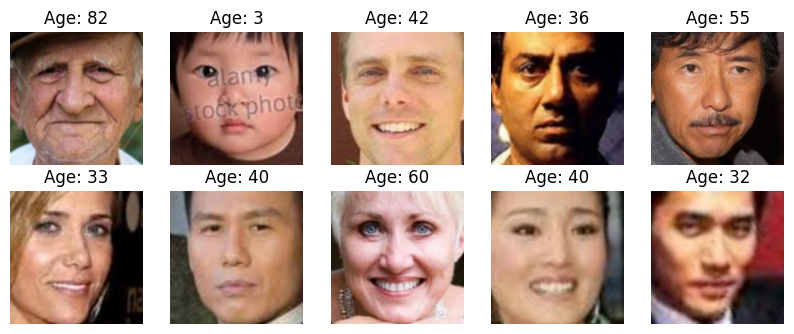

In [4]:
plt.figure(figsize=(10, 10))
files = df.iloc[0:10]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

<Axes: xlabel='age', ylabel='Count'>

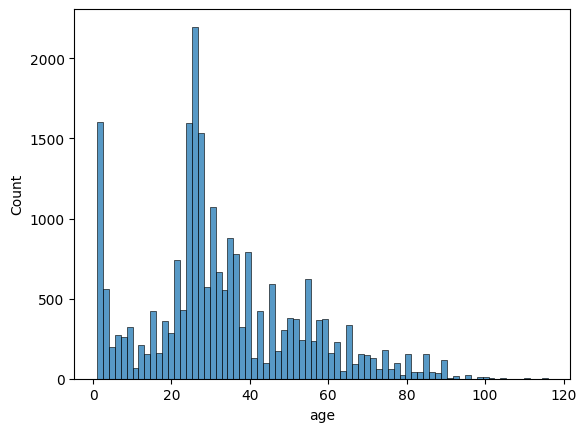

In [5]:
sns.histplot(df['age'])

# Feature Engineering

In [4]:
def image_processing(images):
    features = []
    for image in images:
        img = load_img(image, color_mode="grayscale")
        img = img.resize((128, 128), Image.NONE)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [5]:
X_raw = image_processing(df['image'])
np.shape(X_raw)

(23708, 128, 128, 1)

# Feature Extractor

### HoG (Histogram of Oriented Gradients)

In [6]:
X_hog = []

for i in range(len(X_raw)):
    # Compute HOG features
    hog_features = feature.hog(X_raw[i, :, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

    X_hog.append(hog_features)

X_hog = np.array(X_hog)

### Bilateral Filter

In [7]:
X_bilateral = []

for i in range(len(X_raw)):
    img = X_raw[i, :, :, 0]
    img = cv2.bilateralFilter(img, 9, 75, 75)
    X_bilateral.append(img)

X_bilateral = np.array(X_bilateral)

# División en Train / Test Sets

In [8]:
print(X_raw.shape)
print(X_hog.shape)
print(X_bilateral.shape)

(23708, 128, 128, 1)
(23708, 512)
(23708, 128, 128)


In [9]:
y = np.array(df['age'])

# División de set de datos
# Imágenes crudas
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Imágenes con Feature Extractor)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Imágenes con Bilateral Filter
X_train_bilat, X_test_bilat, y_train_bilat, y_test_bilat = train_test_split(X_bilateral, y, test_size=0.2, random_state=42)

## Encoding según grupo de edad

In [10]:
y_train_raw_group = []
y_test_raw_group = []
y_train_bilat_group = []
y_test_bilat_group = []
y_train_hog_group = []
y_test_hog_group = []

def encode_ages(new_list, ages):
    for age in ages:
        if age < 12:
            new_list.append(0)
        elif age < 19:
            new_list.append(1)
        elif age < 60:
            new_list.append(2)
        else:
            new_list.append(3)
    return np.array(new_list)

# raw images
y_train_raw_group = encode_ages(y_train_raw_group, y_train_raw)
y_test_raw_group = encode_ages(y_test_raw_group, y_test_raw)
# HoG images
y_train_hog_group = encode_ages(y_train_hog_group, y_train_hog)
y_test_hog_group = encode_ages(y_test_hog_group, y_test_hog)
# bilateral filter images
y_train_bilat_group = encode_ages(y_train_bilat_group, y_train_bilat)
y_test_bilat_group = encode_ages(y_test_bilat_group, y_test_bilat)

# Optimización de hiperparámetros

## MLP Sin Feature Extractor

In [18]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Flatten(input_shape=(128, 128)),
        Dense(512, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=70, batch_size=32, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=5)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

[I 2023-11-03 07:27:38,514] A new study created in memory with name: no-name-a842b2dc-c8b8-471c-b10d-bc01170ee43c
[I 2023-11-03 07:30:24,480] Trial 0 finished with value: 16.10141944885254 and parameters: {'learning_rate': 0.004776071803579125}. Best is trial 0 with value: 16.10141944885254.
[I 2023-11-03 07:33:10,285] Trial 1 finished with value: 8.800264358520508 and parameters: {'learning_rate': 0.000725073164037391}. Best is trial 1 with value: 8.800264358520508.
[I 2023-11-03 07:35:58,402] Trial 2 finished with value: 9.639046669006348 and parameters: {'learning_rate': 0.0006449136904448069}. Best is trial 1 with value: 8.800264358520508.
[I 2023-11-03 07:38:44,373] Trial 3 finished with value: 10.015982627868652 and parameters: {'learning_rate': 6.533162674561901e-05}. Best is trial 1 with value: 8.800264358520508.
[I 2023-11-03 07:41:31,810] Trial 4 finished with value: 9.040787696838379 and parameters: {'learning_rate': 0.0003317913620839034}. Best is trial 1 with value: 8.8002

## MLP Con Feature Extractor

In [19]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Flatten(input_shape=(X_hog.shape[1],)),
        Dense(512, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_hog, y_train_hog, validation_split=0.2, epochs=70, batch_size=32, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=5)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

[I 2023-11-03 07:46:50,524] A new study created in memory with name: no-name-24765dee-3ec5-48f5-b9ab-8ba32e6575e3
[I 2023-11-03 07:48:35,620] Trial 0 finished with value: 9.274555206298828 and parameters: {'learning_rate': 0.002830151242130657}. Best is trial 0 with value: 9.274555206298828.
[I 2023-11-03 07:50:19,877] Trial 1 finished with value: 8.249597549438477 and parameters: {'learning_rate': 4.345639979165982e-05}. Best is trial 1 with value: 8.249597549438477.
[I 2023-11-03 07:52:03,599] Trial 2 finished with value: 11.037790298461914 and parameters: {'learning_rate': 0.005370052160430247}. Best is trial 1 with value: 8.249597549438477.
[I 2023-11-03 07:53:47,463] Trial 3 finished with value: 8.731900215148926 and parameters: {'learning_rate': 2.306067006145709e-05}. Best is trial 1 with value: 8.249597549438477.
[I 2023-11-03 07:55:31,090] Trial 4 finished with value: 15.321125030517578 and parameters: {'learning_rate': 0.006900633428787324}. Best is trial 1 with value: 8.2495

## CNN1 sin Bilateral Filter

In [20]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Conv2D(32, (3, 3), activation="elu", input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="elu"),
        Dropout(0.3),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=10, batch_size=8, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=5)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

[I 2023-11-03 07:58:18,437] A new study created in memory with name: no-name-c65498f1-be16-4759-baa4-dc09d3e638be
2023-11-03 07:58:20.428875: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
[I 2023-11-03 08:00:31,526] Trial 0 finished with value: 15.278789520263672 and parameters: {'learning_rate': 0.0021711267117806073}. Best is trial 0 with value: 15.278789520263672.
[I 2023-11-03 08:02:40,906] Trial 1 finished with value: 16.026578903198242 and parameters: {'learning_rate': 0.004690497517041783}. Best is trial 0 with value: 15.278789520263672.
[I 2023-11-03 08:04:49,932] Trial 2 finished with value: 8.800378799438477 and parameters: {'learning_rate': 0.0005838461710703834}. Best is trial 2 with value: 8.800378799438477.
[I 2023-11-03 08:06:58,549] Trial 3 finished with value: 15.200418472290039 and parameters: {'learning_rate': 0.002687956553384955}. Best is trial 2 with value: 8.800378799438477.
[I 2023-11-03 08:09:06

## CNN1 con Bilateral Filter

In [21]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Conv2D(32, (3, 3), activation="elu", input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="elu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="elu"),
        Dropout(0.3),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_bilat, y_train_bilat, validation_split=0.2, epochs=10, batch_size=8, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=5)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

[I 2023-11-03 08:09:22,488] A new study created in memory with name: no-name-24ca6776-fe15-4f8c-aa13-2354efb8a2b9
[I 2023-11-03 08:11:33,317] Trial 0 finished with value: 8.162093162536621 and parameters: {'learning_rate': 1.811476702329827e-05}. Best is trial 0 with value: 8.162093162536621.
[I 2023-11-03 08:13:43,586] Trial 1 finished with value: 6.924849510192871 and parameters: {'learning_rate': 7.050175061789016e-05}. Best is trial 1 with value: 6.924849510192871.
[I 2023-11-03 08:15:53,751] Trial 2 finished with value: 6.7870330810546875 and parameters: {'learning_rate': 0.0003036851487837441}. Best is trial 2 with value: 6.7870330810546875.
[I 2023-11-03 08:18:06,546] Trial 3 finished with value: 7.872314453125 and parameters: {'learning_rate': 1.042668778292734e-05}. Best is trial 2 with value: 6.7870330810546875.
[I 2023-11-03 08:20:16,118] Trial 4 finished with value: 7.5669097900390625 and parameters: {'learning_rate': 1.5651555447946365e-05}. Best is trial 2 with value: 6.7

## CNN2 sin Bilateral Filter

In [12]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Conv2D(32, (4, 4), activation="elu", input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=10, batch_size=8, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=3)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

[I 2023-11-03 08:34:20,569] A new study created in memory with name: no-name-f1680fb9-8259-4c33-8e57-ae4ea5f1a6a1


## CNN2 con Bilateral Filter

In [ ]:
# Define your Keras model
def create_model(trial, learning_rate):
    mlp_raw = Sequential([
        Conv2D(32, (4, 4), activation="elu", input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (4, 4), activation="elu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="linear")
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return mlp_raw

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    model = create_model(trial, learning_rate)
    
    history = model.fit(X_train_bilat, y_train_bilat, validation_split=0.2, epochs=10, batch_size=8, verbose=0)
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=5)

# Access the best hyperparameters
best_learning_rate = study.best_params['learning_rate']

# MLP

## Sin Feature Extractor

### Entrenamiento

In [11]:
mlp_raw = Sequential([
    Flatten(input_shape=(128, 128)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)
mlp_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = mlp_raw.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=70, batch_size=32)
end_time = time.time()

mlp_raw_time = end_time - start_time
mlp_raw.save('mlp_raw_model.h5')

2023-11-03 00:50:30.454938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248578048 exceeds 10% of free system memory.
2023-11-03 00:50:30.704297: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 248578048 exceeds 10% of free system memory.


Epoch 1/70
475/475 [==============================] - 8s 11ms/step - loss: 393.8657 - mae: 15.1840 - val_loss: 312.0706 - val_mae: 13.1466
Epoch 2/70
475/475 [==============================] - 5s 11ms/step - loss: 287.3246 - mae: 12.7927 - val_loss: 302.3885 - val_mae: 12.3467
Epoch 3/70
475/475 [==============================] - 5s 10ms/step - loss: 256.5605 - mae: 11.8976 - val_loss: 257.1432 - val_mae: 12.1632
Epoch 4/70
475/475 [==============================] - 5s 10ms/step - loss: 251.6085 - mae: 11.7393 - val_loss: 240.0829 - val_mae: 11.6126
Epoch 5/70
475/475 [==============================] - 5s 10ms/step - loss: 250.1430 - mae: 11.7914 - val_loss: 272.7675 - val_mae: 13.0029
Epoch 6/70
475/475 [==============================] - 5s 11ms/step - loss: 238.3723 - mae: 11.4569 - val_loss: 352.8142 - val_mae: 13.7913
Epoch 7/70
475/475 [==============================] - 5s 11ms/step - loss: 239.1414 - mae: 11.5073 - val_loss: 215.2840 - val_mae: 10.5522
Epoch 8/70
475/475 [=======

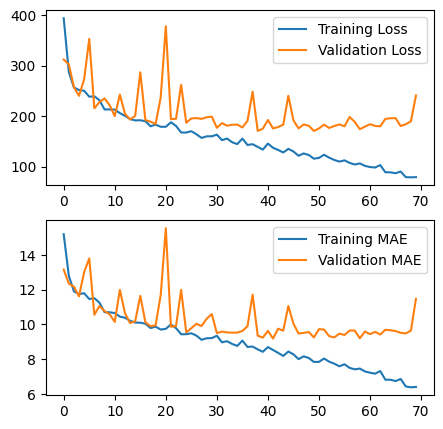

In [12]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [13]:
y_pred = mlp_raw.predict(X_test_raw)
y_pred_train = mlp_raw.predict(X_train_raw)

mlp_raw_mae = mean_absolute_error(y_test_raw, y_pred)
mlp_raw_train_mae = mean_absolute_error(y_train_raw, y_pred_train)
mlp_raw_mse = mean_squared_error(y_test_raw, y_pred)
mlp_raw_train_mse = mean_squared_error(y_train_raw, y_pred_train)

print(f"Test MAE: {mlp_raw_mae}")
print(f"Train MAE: {mlp_raw_train_mae}")
print(f"Test MSE: {mlp_raw_mse}")
print(f"Train MSE: {mlp_raw_train_mse}")

149/149 [==============================] - 1s 3ms/step


2023-11-03 00:56:31.789998: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 310738944 exceeds 10% of free system memory.


593/593 [==============================] - 2s 3ms/step
Test MAE: 11.551690774117779
Train MAE: 9.252607484677416
Test MSE: 238.51825528275288
Train MSE: 149.91308840716314


In [14]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,44.736931,6.736931,45.386237
1,10,34.656677,24.656677,607.951733
2,24,38.639557,14.639557,214.316626
3,56,72.063507,16.063507,258.036260
4,53,66.168854,13.168854,173.418709
5,28,36.445274,8.445274,71.322659
6,47,59.035927,12.035927,144.863534
7,18,29.997570,11.997570,143.941687
8,57,49.351234,7.648766,58.503615
9,36,55.548897,19.548897,382.159366


### Clasificación en grupos de edad

In [15]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

mlp_raw_accuracy = accuracy_score(y_test_raw_group, y_pred_group)
mlp_raw_precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
mlp_raw_recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
mlp_raw_f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [mlp_raw_accuracy, mlp_raw_precision, mlp_raw_recall, mlp_raw_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.769507,0.810134
Precision,0.776619,0.810106
Recall,0.769507,0.810134
F1,0.767411,0.804393


## Con Feature Extractor

### Entrenamiento

In [22]:
mlp_hog = Sequential([
    Flatten(input_shape=(X_hog.shape[1],)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)
mlp_hog.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = mlp_hog.fit(X_train_hog, y_train_hog, validation_split=0.2, epochs=30, batch_size=32)
end_time = time.time()

mlp_hog_time = end_time - start_time
mlp_hog.save('mlp_hog_model.h5')

Epoch 1/30
475/475 [==============================] - 7s 10ms/step - loss: 384.9845 - mae: 14.7899 - val_loss: 224.2520 - val_mae: 11.5280
Epoch 2/30
475/475 [==============================] - 4s 9ms/step - loss: 213.2252 - mae: 11.3042 - val_loss: 186.5057 - val_mae: 10.5127
Epoch 3/30
475/475 [==============================] - 5s 10ms/step - loss: 187.2097 - mae: 10.3669 - val_loss: 179.5347 - val_mae: 9.9133
Epoch 4/30
475/475 [==============================] - 5s 10ms/step - loss: 172.7705 - mae: 9.8043 - val_loss: 184.1762 - val_mae: 10.5978
Epoch 5/30
475/475 [==============================] - 5s 9ms/step - loss: 167.8004 - mae: 9.5975 - val_loss: 176.9052 - val_mae: 9.6774
Epoch 6/30
475/475 [==============================] - 5s 10ms/step - loss: 156.4538 - mae: 9.1811 - val_loss: 159.4008 - val_mae: 9.0984
Epoch 7/30
475/475 [==============================] - 4s 9ms/step - loss: 149.7448 - mae: 8.9786 - val_loss: 153.3731 - val_mae: 9.1643
Epoch 8/30
475/475 [==================

/home/dani/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


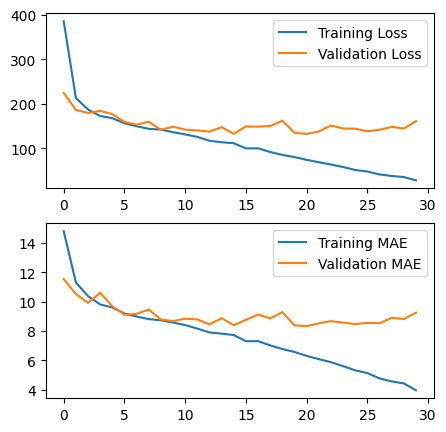

In [25]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [33]:
y_pred = mlp_hog.predict(X_test_hog)
y_pred_train = mlp_hog.predict(X_train_hog)

mlp_hog_mae = mean_absolute_error(y_test_hog, y_pred)
mlp_hog_train_mae = mean_absolute_error(y_train_hog, y_pred_train)
mlp_hog_mse = mean_squared_error(y_test_hog, y_pred)
mlp_hog_train_mse = mean_squared_error(y_train_hog, y_pred_train)

print(f"Test MAE: {mlp_hog_mae}")
print(f"Train MAE: {mlp_hog_train_mae}")
print(f"Test MSE: {mlp_hog_mse}")
print(f"Train MSE: {mlp_hog_train_mse}")

593/593 [==============================] - 2s 3ms/step
Test MAE: 9.265703766695912
Train MAE: 5.560949280979035
Test MSE: 166.97717406906315
Train MSE: 62.21504754630356


In [27]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_hog
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,38.881428,0.881428,0.776915
1,10,27.886679,17.886679,319.933275
2,24,29.044994,5.044994,25.451968
3,56,55.686939,0.313061,0.098007
4,53,52.067680,0.932320,0.869220
5,28,18.692549,9.307451,86.628649
6,47,63.850525,16.850525,283.940189
7,18,25.039551,7.039551,49.555275
8,57,47.436573,9.563427,91.459135
9,36,50.920975,14.920975,222.635487


### Clasificación en grupos de edad

In [28]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

mlp_hog_accuracy = accuracy_score(y_test_hog_group, y_pred_group)
mlp_hog_precision = precision_score(y_test_hog_group, y_pred_group, average='weighted')
mlp_hog_recall = recall_score(y_test_hog_group, y_pred_group, average='weighted')
mlp_hog_f1 = f1_score(y_test_hog_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_hog_group, y_train_pred_group)
precision_train = precision_score(y_train_hog_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_hog_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_hog_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [mlp_hog_accuracy, mlp_hog_precision, mlp_hog_recall, mlp_hog_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.798819,0.872034
Precision,0.796030,0.875265
Recall,0.798819,0.872034
F1,0.794286,0.870821


# CNN1

## Sin Bilateral Filter

### Entrenamiento

In [63]:
cnn1_raw = Sequential([
    Conv2D(32, (3, 3), activation="elu", input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="elu"),
    Dropout(0.3),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=0.0001)
cnn1_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = cnn1_raw.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=10, batch_size=8)
end_time = time.time()

cnn1_raw_time = end_time - start_time
cnn1_raw.save('cnn1_raw_model.h5')

Epoch 1/10
1897/1897 [==============================] - 20s 9ms/step - loss: 228.3658 - mae: 11.3025 - val_loss: 147.3059 - val_mae: 9.4281
Epoch 2/10
1897/1897 [==============================] - 18s 9ms/step - loss: 127.5910 - mae: 8.5119 - val_loss: 128.7554 - val_mae: 8.9769
Epoch 3/10
1897/1897 [==============================] - 18s 9ms/step - loss: 100.9710 - mae: 7.5122 - val_loss: 96.0494 - val_mae: 7.1296
Epoch 4/10
1897/1897 [==============================] - 18s 9ms/step - loss: 83.9962 - mae: 6.8669 - val_loss: 82.0395 - val_mae: 6.6830
Epoch 5/10
1897/1897 [==============================] - 18s 9ms/step - loss: 71.1539 - mae: 6.3868 - val_loss: 86.1483 - val_mae: 6.9395
Epoch 6/10
1897/1897 [==============================] - 18s 9ms/step - loss: 61.7410 - mae: 5.9753 - val_loss: 81.7227 - val_mae: 6.6091
Epoch 7/10
1897/1897 [==============================] - 18s 9ms/step - loss: 53.6309 - mae: 5.5721 - val_loss: 93.1915 - val_mae: 7.3181
Epoch 8/10
1897/1897 [=============

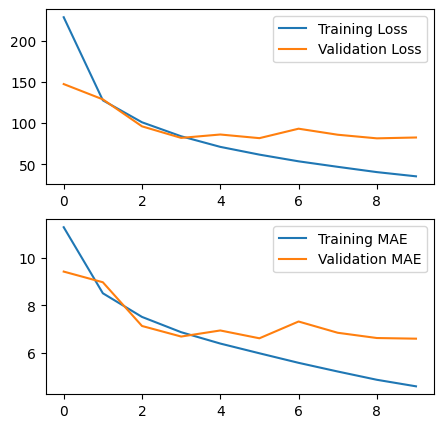

In [64]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [65]:
y_pred = cnn1_raw.predict(X_test_raw)
y_pred_train = cnn1_raw.predict(X_train_raw)

cnn1_raw_mae = mean_absolute_error(y_test_raw, y_pred)
cnn1_raw_train_mae = mean_absolute_error(y_train_raw, y_pred_train)
cnn1_raw_mse = mean_squared_error(y_test_raw, y_pred)
cnn1_raw_train_mse = mean_squared_error(y_train_raw, y_pred_train)

print(f"Test MAE: {cnn1_raw_mae}")
print(f"Train MAE: {cnn1_raw_train_mae}")
print(f"Test MSE: {cnn1_raw_mse}")
print(f"Train MSE: {cnn1_raw_train_mse}")

593/593 [==============================] - 4s 6ms/step
Test MAE: 6.524993191538783
Train MAE: 4.2310350818007
Test MSE: 80.79930170525972
Train MSE: 34.5938873812953


In [66]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,33.620861,4.379139,19.176858
1,10,15.655738,5.655738,31.987371
2,24,30.331594,6.331594,40.089088
3,56,44.483776,11.516224,132.623413
4,53,60.383396,7.383396,54.514539
5,28,26.502226,1.497774,2.243327
6,47,47.713287,0.713287,0.508779
7,18,22.186476,4.186476,17.526579
8,57,61.487846,4.487846,20.140765
9,36,29.428370,6.571630,43.186327


### Clasificación en grupos de edad

In [67]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

cnn1_raw_accuracy = accuracy_score(y_test_raw_group, y_pred_group)
cnn1_raw_precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
cnn1_raw_recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
cnn1_raw_f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [cnn1_raw_accuracy, cnn1_raw_precision, cnn1_raw_recall, cnn1_raw_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.852594,0.906939
Precision,0.850546,0.902743
Recall,0.852594,0.906939
F1,0.849896,0.904344


## Con Bilateral Filter

### Entrenamiento

In [68]:
cnn1_bilat = Sequential([
    Conv2D(32, (3, 3), activation="elu", input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="elu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="elu"),
    Dropout(0.3),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=0.0001)
cnn1_bilat.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = cnn1_bilat.fit(X_train_bilat, y_train_bilat, validation_split=0.2, epochs=10, batch_size=8)
end_time = time.time()

cnn1_bilat_time = end_time - start_time
cnn1_bilat.save('cnn1_bilat_model.h5')

Epoch 1/10
1897/1897 [==============================] - 20s 10ms/step - loss: 227.2901 - mae: 11.3316 - val_loss: 153.6027 - val_mae: 9.3430
Epoch 2/10
1897/1897 [==============================] - 18s 9ms/step - loss: 141.1142 - mae: 8.8999 - val_loss: 124.1936 - val_mae: 8.3775
Epoch 3/10
1897/1897 [==============================] - 18s 9ms/step - loss: 115.0667 - mae: 8.0093 - val_loss: 115.6555 - val_mae: 7.8095
Epoch 4/10
1897/1897 [==============================] - 18s 9ms/step - loss: 99.7188 - mae: 7.4962 - val_loss: 113.0042 - val_mae: 7.9786
Epoch 5/10
1897/1897 [==============================] - 18s 9ms/step - loss: 87.1160 - mae: 7.0537 - val_loss: 100.2175 - val_mae: 7.4856
Epoch 6/10
1897/1897 [==============================] - 18s 9ms/step - loss: 76.2256 - mae: 6.6064 - val_loss: 105.8927 - val_mae: 7.3223
Epoch 7/10
1897/1897 [==============================] - 18s 9ms/step - loss: 67.5821 - mae: 6.2145 - val_loss: 91.8000 - val_mae: 7.0598
Epoch 8/10
1897/1897 [========

/home/dani/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


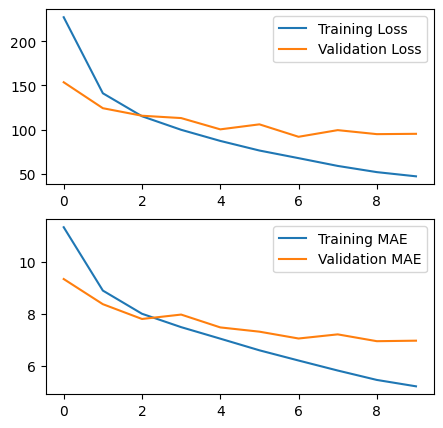

In [69]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [73]:
y_pred = cnn1_bilat.predict(X_test_bilat)
y_pred_train = cnn1_bilat.predict(X_train_bilat)

cnn1_bilat_mae = mean_absolute_error(y_test_bilat, y_pred)
cnn1_bilat_train_mae = mean_absolute_error(y_train_bilat, y_pred_train)
cnn1_bilat_mse = mean_squared_error(y_test_bilat, y_pred)
cnn1_bilat_train_mse = mean_squared_error(y_train_bilat, y_pred_train)

print(f"Test MAE: {cnn1_bilat_mae}")
print(f"Train MAE: {cnn1_bilat_train_mae}")
print(f"Test MSE: {cnn1_bilat_mse}")
print(f"Train MSE: {cnn1_bilat_train_mse}")

593/593 [==============================] - 4s 6ms/step
Test MAE: 6.982920847478068
Train MAE: 4.873205682052806
Test MSE: 93.93195253891102
Train MSE: 45.929321526502925


In [74]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_bilat
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,36.907040,1.092960,1.194562
1,10,20.510231,10.510231,110.464956
2,24,33.674736,9.674736,93.600517
3,56,53.419300,2.580700,6.660012
4,53,61.971817,8.971817,80.493501
5,28,24.893419,3.106581,9.650844
6,47,46.120056,0.879944,0.774301
7,18,25.908447,7.908447,62.543538
8,57,43.616203,13.383797,179.126014
9,36,32.707554,3.292446,10.840202


### Clasificación en grupos de edad

In [76]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

cnn1_bilat_accuracy = accuracy_score(y_test_bilat_group, y_pred_group)
cnn1_bilat_precision = precision_score(y_test_bilat_group, y_pred_group, average='weighted')
cnn1_bilat_recall = recall_score(y_test_bilat_group, y_pred_group, average='weighted')
cnn1_bilat_f1 = f1_score(y_test_bilat_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_bilat_group, y_train_pred_group)
precision_train = precision_score(y_train_bilat_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_bilat_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_bilat_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [cnn1_bilat_accuracy, cnn1_bilat_precision, cnn1_bilat_recall, cnn1_bilat_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.839519,0.886165
Precision,0.839945,0.883629
Recall,0.839519,0.886165
F1,0.828850,0.879174


# CNN2

## Sin Bilateral Filter

### Entrenamiento

In [107]:
cnn2_raw = Sequential([
    Conv2D(32, (4, 4), activation="elu", input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=0.0001)
cnn2_raw.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = cnn2_raw.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=10, batch_size=8)
end_time = time.time()

cnn2_raw_time = end_time - start_time
cnn2_raw.save('cnn2_raw_model.h5')

Epoch 1/10
1897/1897 [==============================] - 25s 12ms/step - loss: 194.7048 - mae: 10.4340 - val_loss: 104.5400 - val_mae: 7.6840
Epoch 2/10
1897/1897 [==============================] - 22s 12ms/step - loss: 107.8393 - mae: 7.7789 - val_loss: 88.6661 - val_mae: 7.0242
Epoch 3/10
1897/1897 [==============================] - 22s 12ms/step - loss: 84.9444 - mae: 6.9084 - val_loss: 85.8995 - val_mae: 6.9393
Epoch 4/10
1897/1897 [==============================] - 22s 12ms/step - loss: 70.4786 - mae: 6.3334 - val_loss: 82.1725 - val_mae: 6.7791
Epoch 5/10
1897/1897 [==============================] - 22s 12ms/step - loss: 58.7038 - mae: 5.7839 - val_loss: 75.1613 - val_mae: 6.3119
Epoch 6/10
1897/1897 [==============================] - 22s 12ms/step - loss: 49.0403 - mae: 5.2897 - val_loss: 82.6569 - val_mae: 6.5346
Epoch 7/10
1897/1897 [==============================] - 22s 12ms/step - loss: 41.5486 - mae: 4.8853 - val_loss: 74.9418 - val_mae: 6.3556
Epoch 8/10
1897/1897 [========

/home/dani/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


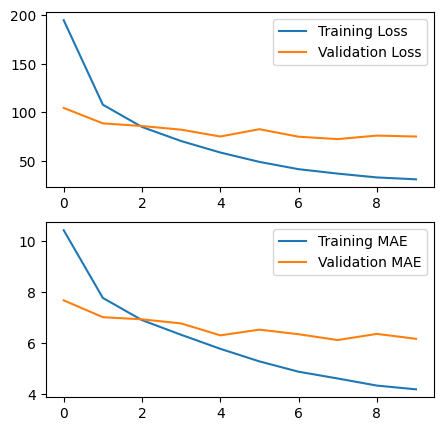

In [108]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [109]:
y_pred = cnn2_raw.predict(X_test_raw)
y_pred_train = cnn2_raw.predict(X_train_raw)

cnn2_raw_mae = mean_absolute_error(y_test_raw, y_pred)
cnn2_raw_train_mae = mean_absolute_error(y_train_raw, y_pred_train)
cnn2_raw_mse = mean_squared_error(y_test_raw, y_pred)
cnn2_raw_train_mse = mean_squared_error(y_train_raw, y_pred_train)

print(f"Test MAE: {cnn2_raw_mae}")
print(f"Train MAE: {cnn2_raw_train_mae}")
print(f"Test MSE: {cnn2_raw_mse}")
print(f"Train MSE: {cnn2_raw_train_mse}")

593/593 [==============================] - 4s 7ms/step
Test MAE: 6.267089451678515
Train MAE: 3.800467475593486
Test MSE: 77.69774569094398
Train MSE: 30.250381125570893


In [110]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test['MAE'] = abs(df_test['Real Ages'] - df_test['Predicted Ages'])
df_test['MSE'] = (df_test['Real Ages'] - df_test['Predicted Ages'])**2
df_test.head(10)

,Real Ages,Predicted Ages,MAE,MSE
0,38,28.826111,9.173889,84.160242
1,10,7.833101,2.166899,4.695450
2,24,30.140120,6.140120,37.701068
3,56,55.001625,0.998375,0.996753
4,53,54.005119,1.005119,1.010265
5,28,24.035982,3.964018,15.713438
6,47,49.406826,2.406826,5.792811
7,18,22.169004,4.169004,17.380598
8,57,58.555595,1.555595,2.419877
9,36,28.018574,7.981426,63.703165


### Clasificación en grupos de edad

In [111]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

cnn2_raw_accuracy = accuracy_score(y_test_raw_group, y_pred_group)
cnn2_raw_precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
cnn2_raw_recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
cnn2_raw_f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [cnn2_raw_accuracy, cnn2_raw_precision, cnn2_raw_recall, cnn2_raw_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.854492,0.911420
Precision,0.850790,0.909354
Recall,0.854492,0.911420
F1,0.847331,0.908507


## Con Bilateral Filter

### Entrenamiento

In [112]:
cnn2_bilat = Sequential([
    Conv2D(32, (4, 4), activation="elu", input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (4, 4), activation="elu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=0.0001)
cnn2_bilat.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

start_time = time.time()
history = cnn2_bilat.fit(X_train_bilat, y_train_bilat, validation_split=0.2, epochs=10, batch_size=8)
end_time = time.time()

cnn2_bilat_time = end_time - start_time
cnn2_bilat.save('cnn2_bilat_model.h5')

Epoch 1/10
1897/1897 [==============================] - 26s 13ms/step - loss: 231.3477 - mae: 11.4267 - val_loss: 151.6561 - val_mae: 9.1100
Epoch 2/10
1897/1897 [==============================] - 23s 12ms/step - loss: 146.1534 - mae: 9.0850 - val_loss: 120.0022 - val_mae: 8.0544
Epoch 3/10
1897/1897 [==============================] - 23s 12ms/step - loss: 115.9424 - mae: 8.0520 - val_loss: 104.2144 - val_mae: 7.5686
Epoch 4/10
1897/1897 [==============================] - 22s 12ms/step - loss: 104.3809 - mae: 7.6557 - val_loss: 98.1593 - val_mae: 7.1643
Epoch 5/10
1897/1897 [==============================] - 21s 11ms/step - loss: 90.2579 - mae: 7.1400 - val_loss: 102.9199 - val_mae: 7.4739
Epoch 6/10
1897/1897 [==============================] - 21s 11ms/step - loss: 77.1846 - mae: 6.6355 - val_loss: 112.8205 - val_mae: 7.5873
Epoch 7/10
1897/1897 [==============================] - 22s 11ms/step - loss: 67.8464 - mae: 6.2183 - val_loss: 97.0945 - val_mae: 7.0318
Epoch 8/10
1897/1897 [==

/home/dani/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


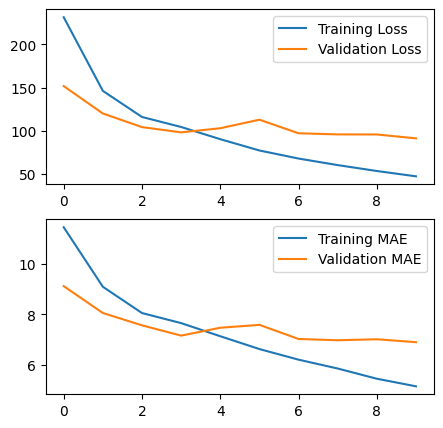

In [113]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de edad

In [114]:
y_pred = cnn2_bilat.predict(X_test_bilat)
y_pred_train = cnn2_bilat.predict(X_train_bilat)

cnn2_bilat_mae = mean_absolute_error(y_test_bilat, y_pred)
cnn2_bilat_train_mae = mean_absolute_error(y_train_bilat, y_pred_train)
cnn2_bilat_mse = mean_squared_error(y_test_bilat, y_pred)
cnn2_bilat_train_mse = mean_squared_error(y_train_bilat, y_pred_train)

print(f"Test MAE: {cnn2_bilat_mae}")
print(f"Train MAE: {cnn2_bilat_train_mae}")
print(f"Test MSE: {cnn2_bilat_mse}")
print(f"Train MSE: {cnn2_bilat_train_mse}")

593/593 [==============================] - 4s 7ms/step
Test MAE: 6.855961018030224
Train MAE: 4.683935761319335
Test MSE: 91.39152302888262
Train MSE: 41.95209267629832


### Clasificación en grupos de edad

In [115]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

cnn2_bilat_accuracy = accuracy_score(y_test_bilat_group, y_pred_group)
cnn2_bilat_precision = precision_score(y_test_bilat_group, y_pred_group, average='weighted')
cnn2_bilat_recall = recall_score(y_test_bilat_group, y_pred_group, average='weighted')
cnn2_bilat_f1 = f1_score(y_test_bilat_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_bilat_group, y_train_pred_group)
precision_train = precision_score(y_train_bilat_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_bilat_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_bilat_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [cnn2_bilat_accuracy, cnn2_bilat_precision, cnn2_bilat_recall, cnn2_bilat_f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

,Test,Train
Accuracy,0.847533,0.888274
Precision,0.843202,0.884860
Recall,0.847533,0.888274
F1,0.840168,0.884358


# Comparación de modelos

In [116]:
metrics_results = pd.DataFrame()
metrics_results['MAE'] = [mlp_raw_mae, mlp_hog_mae, cnn1_raw_mae, cnn1_bilat_mae, cnn2_raw_mae, cnn2_bilat_mae]
metrics_results['MSE'] = [mlp_raw_mse, mlp_hog_mse, cnn1_raw_mse, cnn1_bilat_mse, cnn2_raw_mse, cnn2_bilat_mse]
metrics_results['Accuracy'] = [mlp_raw_accuracy, mlp_hog_accuracy, cnn1_raw_accuracy, cnn1_bilat_accuracy, cnn2_raw_accuracy, cnn2_bilat_accuracy]
metrics_results['Precision'] = [mlp_raw_precision, mlp_hog_precision, cnn1_raw_precision, cnn1_bilat_precision, cnn2_raw_precision, cnn2_bilat_precision]
metrics_results['Recall'] = [mlp_raw_recall, mlp_hog_recall, cnn1_raw_recall, cnn1_bilat_recall, cnn2_raw_recall, cnn2_bilat_recall]
metrics_results['F1'] = [mlp_raw_f1, mlp_hog_f1, cnn1_raw_f1, cnn1_bilat_f1, cnn2_raw_f1, cnn2_bilat_f1]
metrics_results['Tiempo de entrenamiento'] = [mlp_raw_time, mlp_hog_time, cnn1_raw_time, cnn1_bilat_time, cnn2_raw_time, cnn2_bilat_time]
metrics_results.index = ["MLP Crudo", "MLP Feature Extractor", "CNN1 Crudo", "CNN1 Bilateral Filter", "CNN2 Crudo", "CNN2 Bilateral Filter"]
metrics_results

,MAE,MSE,Accuracy,Precision,Recall,F1,Tiempo de entrenamiento
MLP Crudo,9.961373,185.604239,0.796499,0.780886,0.796499,0.780040,335.931033
MLP Feature Extractor,9.265704,166.977174,0.798819,0.796030,0.798819,0.794286,138.184504
CNN1 Crudo,6.524993,80.799302,0.852594,0.850546,0.852594,0.849896,180.173033
CNN1 Bilateral Filter,6.982921,93.931953,0.839519,0.839945,0.839519,0.828850,181.223257
CNN2 Crudo,6.267089,77.697746,0.854492,0.850790,0.854492,0.847331,223.319001
CNN2 Bilateral Filter,6.855961,91.391523,0.847533,0.843202,0.847533,0.840168,222.597382


# Interfaz Gráfica

In [125]:
GPIO.setwarnings(False)
GPIO.setmode(GPIO.BOARD)
GPIO.setup(11, GPIO.OUT)
GPIO.setup(13, GPIO.OUT)
GPIO.setup(15, GPIO.OUT)
GPIO.setup(19, GPIO.OUT)

models = ["MLP Crudo", "MLP Feature Extractor", "CNN1 Crudo", "CNN1 Bilateral Filter", "CNN2 Crudo", "CNN2 Bilateral Filter"]

# Browse button to select an image
def browse_file():
    file_path = filedialog.askopenfilename()
    path_label.config(text=file_path)
    show_image(file_path)

# Function to show the selected image
def show_image(file_path):
    image = Image.open(file_path)
    photo = ImageTk.PhotoImage(image)

    # Update the label with the selected image
    image_label.config(image=photo)
    image_label.image = photo 

# Function to apply HoG filter
def apply_hog_filter(image_paths):
    X_hog = []

    for i in range(len(image_paths)):
        # Compute HOG features
        hog_features = feature.hog(image_paths[i, :, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
        X_hog.append(hog_features)

    X_hog = np.array(X_hog)
    return X_hog

# Function to apply bilateral filter
def apply_bilateral_filter(image):
    X_bilateral = []

    for i in range(len(image)):
        bilateral_filtered_image = cv2.bilateralFilter(image[i, :, :, 0], 9, 75, 75)
        bilateral_filtered_image = np.array(bilateral_filtered_image)
        X_bilateral.append(bilateral_filtered_image)

    X_bilateral = np.array(X_bilateral)
    X_bilateral = tf.expand_dims(X_bilateral, axis=-1)
    return X_bilateral

# Function to encode age
def encode_age(age):
    if age < 12:
        return 0
    elif age < 19:
        return 1
    elif age < 60:
        return 2
    else:
        return 3

# Function to encode age group into text
def encode_group(group):
    if group == 0:
        GPIO.output(11, True)
        return "Niño"
    elif group == 1:
        GPIO.output(13, True)
        return "Adolescente"
    elif group == 2:
        GPIO.output(15, True)
        return "Adulto joven"
    else:
        GPIO.output(19, True)
        return "Adulto mayor"

# Function to predict age
def predict_age():
    # Turn off all LEDS
    GPIO.output(11, False)
    GPIO.output(13, False)
    GPIO.output(15, False)
    GPIO.output(19, False)

    # Get the selected model
    selected_model = model_combobox.get()
    
    # Get the selected image file
    file_path = path_label.cget("text")
    
    if not selected_model or not file_path:
        # Show error message
        messagebox.showerror("Error", "Debe seleccionar un modelo y una imagen.")
        return
    
    # Image processing
    processed_image = image_processing([file_path])
    
    # Load the selected model
    if selected_model == models[0]:
        # MLP with raw images
        loaded_model = load_model('models/mlp_raw_model.h5')
    elif selected_model == models[1]:
        # MLP with HoG images
        loaded_model = load_model('models/mlp_hog_model.h5')
        processed_image = apply_hog_filter(processed_image)
    elif selected_model == models[2]:
        # CNN1 with raw images
        loaded_model = load_model('models/cnn1_raw_model.h5')
    elif selected_model == models[3]:
        # CNN1 with bilateral filter images
        loaded_model = load_model('models/cnn1_bilat_model.h5')
        processed_image = apply_bilateral_filter(processed_image)
    elif selected_model == models[4]:
        # CNN2 with raw images
        loaded_model = load_model('models/cnn2_raw_model.h5')
    elif selected_model == models[5]:
        # CNN2 with bilateral filter images
        loaded_model = load_model('models/cnn2_bilat_model.h5')
        processed_image = apply_bilateral_filter(processed_image)
    
    # Make predictions
    age_prediction = loaded_model.predict(processed_image)[0][0]
    age_group = encode_age(age_prediction)
    age_group_text = encode_group(age_group)
    
    result_label.config(text=f"Edad predicha: {age_prediction:.2f} años")
    age_group_label.config(text=f"Tipo: {age_group_text}")

    loaded_model = None

# Create the main window
root = tk.Tk()
root.title("Predicción de Edad")

# Create a label for the file path
file_label = tk.Label(root, text="Seleccione una imagen:")
file_label.pack()
    
# Create a button to browse files
browse_button = tk.Button(root, text="Buscar...", command=browse_file)
browse_button.pack()

# Create a label to display the selected file path
path_label = tk.Label(root, width=100, anchor="w")
path_label.pack()

# Create a label to display the selected image
image_label = tk.Label(root)
image_label.pack()

# Create a label for model selection
model_label = tk.Label(root, text="Seleccione un modelo:")
model_label.pack()

# Dropdown for model selection
model_combobox = ttk.Combobox(root, values=models, state="readonly")
model_combobox.pack()

# Button to predict age
predict_button = tk.Button(root, text="Probar modelo", command=predict_age)
predict_button.pack()

# Label to display the prediction result
result_label = tk.Label(root, text="Edad predicha: ")
result_label.pack()

# Label to display the age group
age_group_label = tk.Label(root, text="Tipo: ")
age_group_label.pack()

# Start the main event loop
root.mainloop()

GPIO.output(11, False)
GPIO.output(13, False)
GPIO.output(15, False)
GPIO.output(19, False)

1/1 [==============================] - 0s 104ms/step
(1, 128, 128)
1/1 [==============================] - 0s 93ms/step
(1, 128, 128)
1/1 [==============================] - 0s 23ms/step
